Step 1: Load the Dataset

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Define the correct path to your dataset
file_path = "/"

# Load data
df = pd.read_csv(file_path)

# Display basic info
df.info()

# Preview first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181458 entries, 0 to 181457
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         181458 non-null  object 
 1   County                                             181455 non-null  object 
 2   City                                               181455 non-null  object 
 3   State                                              181458 non-null  object 
 4   Postal Code                                        181455 non-null  float64
 5   Model Year                                         181458 non-null  int64  
 6   Make                                               181458 non-null  object 
 7   Model                                              181458 non-null  object 
 8   Electric Vehicle Type                              181458 non-null  object

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WAUTPBFF4H,King,Seattle,WA,98126.0,2017,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,34.0,235085336,POINT (-122.374105 47.54468),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,WAUUPBFF2J,Thurston,Olympia,WA,98502.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,22.0,237896795,POINT (-122.943445 47.059252),PUGET SOUND ENERGY INC,5.306701e+10
2,5YJSA1E22H,Thurston,Lacey,WA,98516.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,22.0,154498865,POINT (-122.78083 47.083975),PUGET SOUND ENERGY INC,5.306701e+10
3,1C4JJXP62M,Thurston,Tenino,WA,98589.0,2021,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,20.0,154525493,POINT (-122.85403 46.856085),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJ3E1EC9L,Yakima,Yakima,WA,98902.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,14.0,225996361,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10


Step 2: Data Cleaning

1. Identify and Count Missing Values

In [4]:
# Count missing values per column
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

County                    3
City                      3
Postal Code               3
Legislative District    398
Vehicle Location          8
Electric Utility          3
2020 Census Tract         3
dtype: int64

2. Identify and Remove Duplicates

In [5]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates
df = df.drop_duplicates()

Number of duplicate rows: 0


3. Replace Missing Values

In [6]:
# Fill categorical missing values with mode (most frequent value)
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Fill numerical missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.median()))

# Verify missing values are filled
print(df.isnull().sum())

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64


4. Detect and Handle Outliers in Base MSRP (Price) Using Statistical Methods

In [7]:
# Define the column for price analysis
price_col = 'Base MSRP'

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[price_col].quantile(0.25)
Q3 = df[price_col].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers before replacing
outliers_before = df[(df[price_col] < lower_bound) | (df[price_col] > upper_bound)]
print(f"Number of outliers detected: {len(outliers_before)}")
print("Outliers before replacement:", "\n")
print(outliers_before[[price_col]].head())

# Cap outliers
df[price_col] = np.where(df[price_col] > upper_bound, upper_bound, df[price_col])
df[price_col] = np.where(df[price_col] < lower_bound, lower_bound, df[price_col])

# Identify outliers after replacing
outliers_after = df[(df[price_col] < lower_bound) | (df[price_col] > upper_bound)]
print(f"Number of outliers remaining after replacement: {len(outliers_after)}")
print("")

# Verify the changes
print(df[price_col].describe())  

Number of outliers detected: 3312
Outliers before replacement: 

     Base MSRP
119      69900
170      69900
171      64950
318      39995
326      53400
Number of outliers remaining after replacement: 0

count    181458.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Base MSRP, dtype: float64


5. Convert Categorical Data into Numerical Format

In [8]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Apply Label Encoding for binary categorical columns
label_enc_cols = [col for col in cat_cols if df[col].nunique() == 2]
le = LabelEncoder()
for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])

# Apply One-Hot Encoding for multi-class categorical columns
multi_class_cols = [col for col in cat_cols if df[col].nunique() > 2]
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

print("Categorical encoding complete.")
print (df.head())

Categorical encoding complete.
   Postal Code  Model Year  Electric Vehicle Type  Electric Range  Base MSRP  \
0      98126.0        2017                      1              16        0.0   
1      98502.0        2018                      1              16        0.0   
2      98516.0        2017                      0             210        0.0   
3      98589.0        2021                      1              25        0.0   
4      98902.0        2020                      0             308        0.0   

   Legislative District  DOL Vehicle ID  2020 Census Tract  \
0                  34.0       235085336       5.303301e+10   
1                  22.0       237896795       5.306701e+10   
2                  22.0       154498865       5.306701e+10   
3                  20.0       154525493       5.306701e+10   
4                  14.0       225996361       5.307700e+10   

   VIN (1-10)_1C4JJXN61P  VIN (1-10)_1C4JJXN62P  ...  \
0                  False                  False  ...   
1  

Step 3: Exploratory Data Analysis (EDA)

1. Calculate Summary Statistics

In [9]:
# Summary statistics for numerical columns
print(df.describe())

         Postal Code     Model Year  Electric Vehicle Type  Electric Range  \
count  181458.000000  181458.000000          181458.000000   181458.000000   
mean    98174.049857    2020.581793               0.217599       57.826665   
std      2414.222020       2.991140               0.412614       91.396074   
min      1545.000000    1997.000000               0.000000        0.000000   
25%     98052.000000    2019.000000               0.000000        0.000000   
50%     98122.000000    2022.000000               0.000000        0.000000   
75%     98370.000000    2023.000000               0.000000       75.000000   
max     99577.000000    2024.000000               1.000000      337.000000   

       Base MSRP  Legislative District  DOL Vehicle ID  2020 Census Tract  
count   181458.0         181458.000000    1.814580e+05       1.814580e+05  
mean         0.0             29.115443    2.214128e+08       5.297576e+10  
std          0.0             14.877116    7.528561e+07       1.594863

2. Create Correlation Matrix

In [ ]:
# Compute correlation matrix
corr_matrix = df.corr()

# Identify the strongest and weakest correlations
strong_corr = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
print("Strongest Correlations:\n", strong_corr.head(10))
print("\nWeakest Correlations:\n", strong_corr.tail(10))

Step 4: Visualizations

Histogram

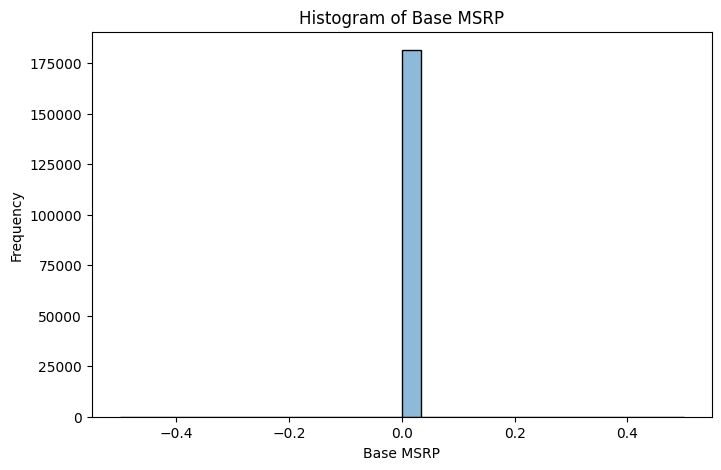

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(df['Base MSRP'], bins=30, kde=True)
plt.title("Histogram of Base MSRP")
plt.xlabel("Base MSRP")
plt.ylabel("Frequency")
plt.show()

Pairplot

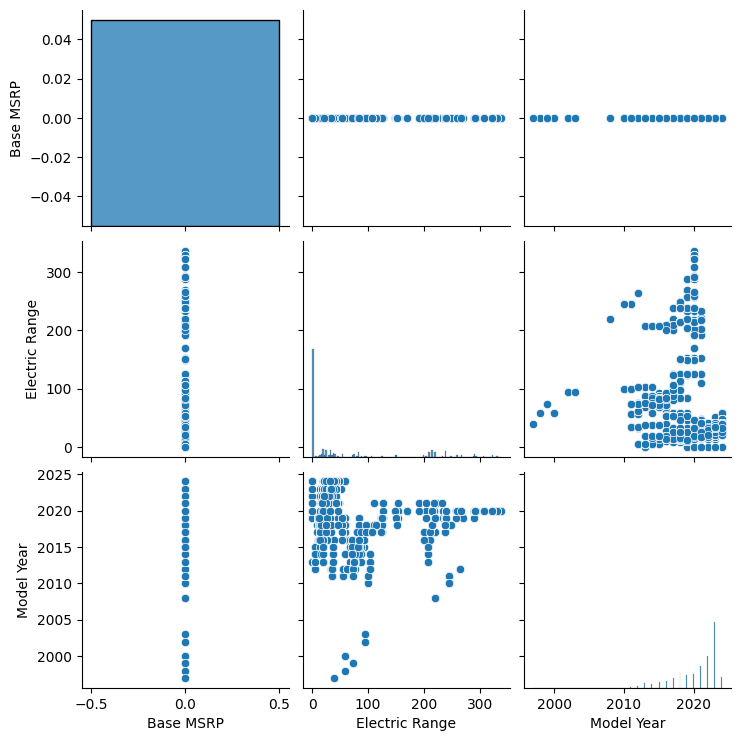

In [11]:
sns.pairplot(df[['Base MSRP', 'Electric Range', 'Model Year']])
plt.show()

Heat Map

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Feature Correlations")
plt.show()

Violin Plot

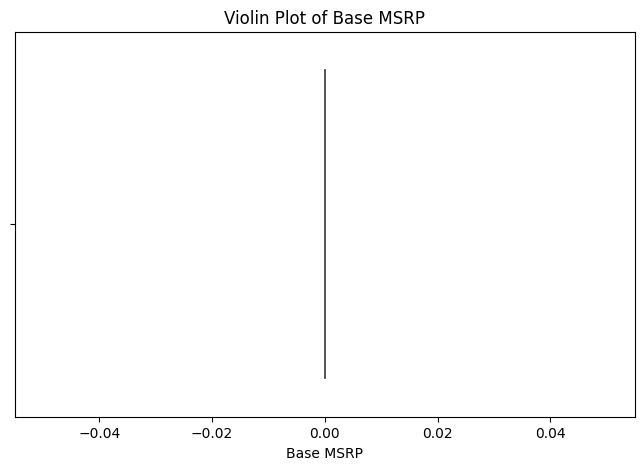

In [12]:
plt.figure(figsize=(8,5))
sns.violinplot(x=df['Base MSRP'])
plt.title("Violin Plot of Base MSRP")
plt.xlabel("Base MSRP")
plt.show()

Countplot

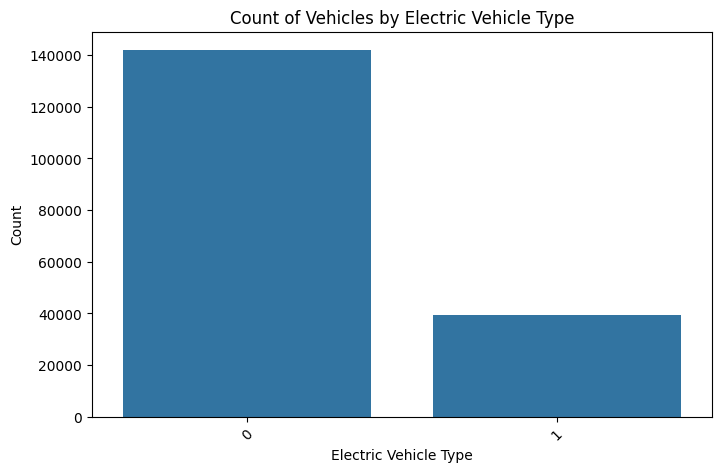

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Electric Vehicle Type'])
plt.title("Count of Vehicles by Electric Vehicle Type")
plt.xlabel("Electric Vehicle Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Bubble Chart

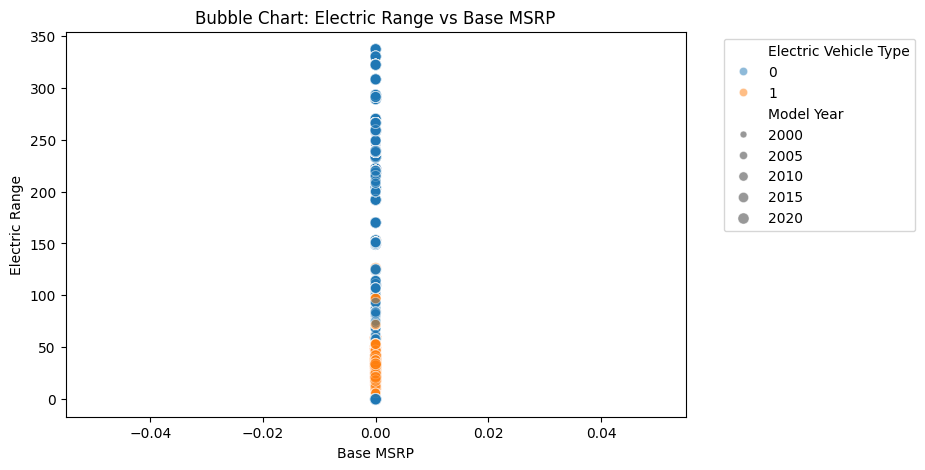

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=df['Base MSRP'],                
    y=df['Electric Range'],           
    size=df['Model Year'],            
    hue=df['Electric Vehicle Type'],
    alpha=0.5
)
plt.title("Bubble Chart: Electric Range vs Base MSRP")
plt.xlabel("Base MSRP")
plt.ylabel("Electric Range")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()